In [18]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set()
#Pull in CSV paths
csvHL = "Resources/2007-2016-Homelessnewss-USA.csv"
csvRP = "Resources/price.csv"
csvpop = "Resources/datasets_1697_3211_Population-by-state (1).csv"
csvPPSQFT = "Resources/pricepersqft.csv"

In [2]:
#Prep CSV Paths for DataFrames
homeless_data = pd.read_csv(csvHL)
rentprice_data = pd.read_csv(csvRP)
population_data = pd.read_csv(csvpop)
pricepersqft_data = pd.read_csv(csvPPSQFT)

In [3]:
#Set DataFrames
homeless_df = pd.DataFrame(homeless_data)
rentprice_df = pd.DataFrame(rentprice_data)
population_df = pd.DataFrame(population_data)
pricepersqft_df = pd.DataFrame(pricepersqft_data)


In [4]:
#Transform Homeless CSV data to match Zillow Data Form

homelessfiltered_df = homeless_df.loc[homeless_df['Measures'] == "Total Homeless"]
#homelessfiltered_df[]
homeless_pdf = homelessfiltered_df.pivot_table(values='Count',
                                               index=homelessfiltered_df.State,
                                               columns='Year',
                                               aggfunc='first'
                                              )

#Reset Index and Rename columns
homeless_pdf.reset_index(inplace=True)
homeless_pdf.columns = ['State',
                        'HR2007',
                        'HR2008',
                        'HR2009',
                        'HR2010',
                        'HR2011',
                        'HR2012',
                        'HR2013',
                        'HR2014',
                        'HR2015',
                        'HR2016'
                       ]
homeless_pdf[["HR2007", "HR2008", "HR2009", "HR2010", "HR2011", "HR2012", "HR2013", "HR2014", "HR2015", "HR2016"]] = homeless_pdf[["HR2007", "HR2008", "HR2009", "HR2010", "HR2011", "HR2012", "HR2013", "HR2014", "HR2015", "HR2016"]].replace(',','', regex=True).astype(float)

#filter Homeless DataFrame to prep for Join with Rent Data, cleaned down to show variance and % CHG from 2011 to 2016
homeless_final = homeless_pdf.filter(['State', 'HR2011', 'HR2016'])
homeless_final["Var"] = homeless_final["HR2016"] - homeless_final["HR2011"]
homeless_final["% CHG"] = homeless_final["Var"] / homeless_final["HR2011"] * 100
homeless_final.head()


,State,HR2011,HR2016,Var,% CHG
0,AK,1223.0,1105.0,-118.0,-9.648406
1,AL,1950.0,1228.0,-722.0,-37.025641
2,AR,1276.0,808.0,-468.0,-36.677116
3,AZ,2047.0,2240.0,193.0,9.428432
4,CA,7067.0,6524.0,-543.0,-7.683600


In [5]:

# Perform Groupby on Rent Data by State with Average rent price
#rentprice_df.filter(['State', 'January 2011', 'January 2016'])
rentprice_mean = rentprice_df.groupby(['State']).mean()
rentprice_mean_years = rentprice_mean.filter(['State',
                                              'January 2011',
                                              'January 2012',
                                              'January 2013',
                                              'January 2014',
                                              'January 2015',
                                              'January 2016',
                                             ])

#Re-name columns to match format from homeless DF
rentprice_mean_years.columns = ['RP2011',
                                'RP2012',
                                'RP2013',
                                'RP2014',
                                'RP2015',
                                'RP2016'
                               ]
#rentprice_mean_years

rentprice_final = rentprice_mean_years.filter(['RP2011', 'RP2016'])
rentprice_final["RP Var"] = rentprice_final["RP2016"] - rentprice_final["RP2011"]
rentprice_final["RP % CHG"] = rentprice_final["RP Var"] / rentprice_final["RP2011"] * 100
rentprice_final.reset_index(inplace=True)
rentprice_final.head()

,State,RP2011,RP2016,RP Var,RP % CHG
0,AK,NaN,1644.000000,NaN,NaN
1,AL,959.351648,1023.484305,64.132657,6.685000
2,AR,828.773050,943.687075,114.914025,13.865560
3,AZ,1197.033613,1233.605042,36.571429,3.055171
4,CA,2019.433604,2322.005376,302.571772,14.983002


In [15]:
combined_df = homeless_final.set_index('State').join(rentprice_final.set_index('State'))
combined_clean = combined_df.dropna()
combined_clean.reset_index(inplace=True)
combined_final = combined_clean.style.format({
                             "RP2011":"${:20,.0f}",
                             "RP2016":"${:20,.0f}",
                             "RP Var":"${:20,.0f}",
                             "RP % CHG":"{:20,.1f}%",
                             "HR2011":"{:20,.0f}",
                             "HR2016":"{:20,.0f}",
                             "Var":"{:20,.0f}",
                             "% CHG":"{:20,.1f}%"
                            })

#combined_final

In [7]:
html = combined_clean.to_html()
#print(html)

In [8]:
# homeless count of total homeless by state by years 2011 to 2016
homeless_pdf

,State,HR2007,HR2008,HR2009,HR2010,HR2011,HR2012,HR2013,HR2014,HR2015,HR2016
0,AK,974.0,1023.0,1267.0,1231.0,1223.0,1147.0,1122.0,1023.0,1208.0,1105.0
1,AL,2104.0,2104.0,2273.0,2273.0,1950.0,1707.0,1469.0,1329.0,1153.0,1228.0
2,AR,1822.0,1811.0,1425.0,1425.0,1276.0,1249.0,1066.0,1074.0,830.0,808.0
3,AZ,2997.0,2940.0,3236.0,3069.0,2047.0,2451.0,2435.0,2398.0,2402.0,2240.0
4,CA,7202.0,7202.0,7086.0,7086.0,7067.0,7053.0,7631.0,7567.0,6556.0,6524.0
5,CO,4450.0,5188.0,5267.0,5267.0,9283.0,9283.0,2267.0,2188.0,3545.0,3520.0
6,CT,919.0,846.0,825.0,944.0,1005.0,902.0,1059.0,1083.0,913.0,886.0
7,DC,5320.0,6044.0,6228.0,6539.0,6546.0,6954.0,6865.0,7748.0,7298.0,8350.0
8,DE,1061.0,933.0,1130.0,982.0,1035.0,1008.0,946.0,901.0,953.0,1070.0
9,FL,1012.0,1361.0,1999.0,1999.0,1152.0,921.0,1049.0,1377.0,1198.0,1468.0


In [27]:
# Rent prices by state by years 2011 to 2016
rentprice_mean_years

,RP2011,RP2012,RP2013,RP2014,RP2015,RP2016
State,,,,,,
WY,NaN,896.285714,1137.333333,1124.904762,1217.857143,1230.190476
WV,1028.795181,1004.915663,1030.303030,1020.464646,1011.808081,1021.454545
WI,889.688406,1075.681159,1193.380319,1194.388298,1211.103723,1216.598404
WA,1359.810345,1343.706897,1351.732441,1414.204013,1468.695652,1555.354515
VT,NaN,1338.505155,1360.546392,1381.051546,1400.185567,1506.525773
VA,1345.042857,1374.320000,1376.880435,1408.817935,1400.100543,1420.399457
UT,NaN,1253.490196,1282.311321,1361.311321,1371.556604,1398.122642
TX,1319.440876,1292.170803,1310.021614,1373.567723,1439.059078,1489.969741
TN,1061.542969,1060.687500,1073.841085,1107.732558,1136.899225,1164.829457


In [11]:
#top rent and states in 2016
top_rent_2016={'States':['CA','DC','HI','MA','NJ','NY'],
              'Var':[2322,2535,2113,2035,2132,1849]
             } 
pd.DataFrame.from_dict(top_rent_2016)

,States,Var
0,CA,2322
1,DC,2535
2,HI,2113
3,MA,2035
4,NJ,2132
5,NY,1849


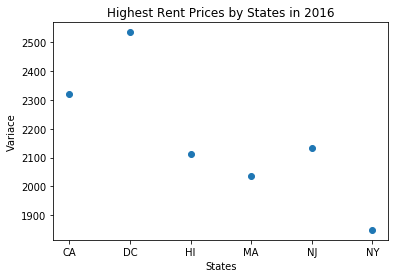

In [17]:
#scatter plot top rent and states in 2016
plt.scatter(top_rent_2016['States'],top_rent_2016['Var'])
plt.xlabel('States')
plt.ylabel('Variace')
plt.title('Highest Rent Prices by States in 2016')
plt.show()

In [22]:
#top 6 states with increase HR (homeless rate) from 2011-2016 using variance and percentage 
hr_increase={'States':['WA','HI','NY','FL','DC','MA'],
              'Var':[1758,1027,166,316,1804,764],
               'Percent':['19.6%','52.6%','23.9%','27.4%','27.6%','14.0%']
             } 
pd.DataFrame.from_dict(hr_increase)

,States,Var,Percent
0,WA,1758,19.6%
1,HI,1027,52.6%
2,NY,166,23.9%
3,FL,316,27.4%
4,DC,1804,27.6%
5,MA,764,14.0%


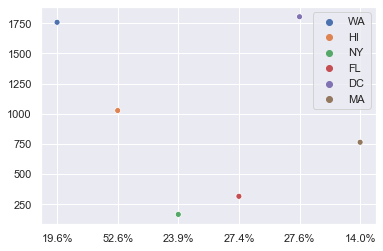

In [23]:
#scatter plot top 6 states with increase HR (homeless rate) from 2011-2016 using variance and percentage
sns.scatterplot(x='Percent', y='Var', hue='States', data =hr_increase)

In [25]:
#top 6 states with rent increases over 2011-2016
rp_increase={'States':['NY','CA','CO','WI','DC','OR'],
              'Var':[462,303,315,327,294,295],
               'Percent':['33.3%','15.0%','22.5%','36.7%','13.1%','26.8%']
             } 
pd.DataFrame.from_dict(rp_increase)

,States,Var,Percent
0,NY,462,33.3%
1,CA,303,15.0%
2,CO,315,22.5%
3,WI,327,36.7%
4,DC,294,13.1%
5,OR,295,26.8%


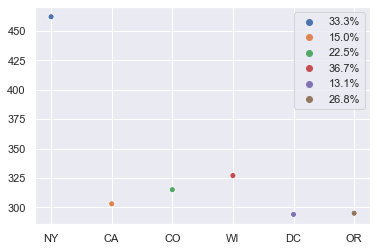

In [26]:
#scatter plot top 6 states with rent increases over 2011-2016
sns.scatterplot(x='States', y='Var', hue='Percent', data =rp_increase)